### Toxic Comment Classification Challenge

https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge

In [25]:
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [26]:
import numpy as np 
import pandas as pd
import string
import re
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer 
from wordcloud import WordCloud
from matplotlib import pyplot as plt
from textblob import TextBlob
from nltk.stem.wordnet import WordNetLemmatizer 
import gensim

In [27]:
df = pd.read_csv('train-2.csv')

### Data Overview

In [28]:
df.head(5)
df.describe()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Add Variable

In [29]:
rowsums=df.iloc[:,2:].sum(axis=1)
df['clean']=(rowsums==0) *1

In [30]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1


### Data Cleaning<br>


In [31]:
corpus = df.comment_text

In [32]:
corpus.head()

0    Explanation\nWhy the edits made under my usern...
1    D'aww! He matches this background colour I'm s...
2    Hey man, I'm really not trying to edit war. It...
3    "\nMore\nI can't make any real suggestions on ...
4    You, sir, are my hero. Any chance you remember...
Name: comment_text, dtype: object

In [33]:
tokenizer=TweetTokenizer()
lem = WordNetLemmatizer()
eng_stopwords = set(stopwords.words("english"))
pun = set(string.punctuation)

In [34]:
def clean(comment):
    """
    This function receives comments and returns clean word-list
    """
    # Convert to lower case , so that Hi and hi are the same
    comment=comment.lower()
    # remove \n
    comment=re.sub("\\n","",comment)
    # remove leaky elements like ip,user
    comment=re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}","",comment)
    # remove usernames
    comment=re.sub("\[\[.*\]","",comment)
 
    
    # Split the sentences into words
    words=tokenizer.tokenize(comment)
    
    # (')aphostophe  replacement (ie)   you're --> you are  
    # ( basic dictionary lookup : master dictionary present in a hidden block of code)
    # remove stopwords and punctuation
    words = [lem.lemmatize(word, "v") for word in words]
    words = [w for w in words if not w in eng_stopwords]
    words = [w for w in words if not w in pun]
    
    clean_sent=" ".join(words)
    
    return(clean_sent)

In [35]:
clean_corpus = corpus.apply(lambda x :clean(x))

In [36]:
df['comment'] = clean_corpus

In [37]:
df.head(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean,comment
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1,explanationwhy edit make username hardcore met...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1,d'aww match background colour i'm seemingly st...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1,hey man i'm really try edit war guy constantly...
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1,morei can't make real suggestions improvement ...
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1,sir hero chance remember page that's


### Crerate subset for text analysis

In [38]:
df_word = pd.concat([df.iloc[:,2:9],df['comment']], axis = 1)

In [39]:
df_word.head(5)

,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean,comment
0,0,0,0,0,0,0,1,explanationwhy edit make username hardcore met...
1,0,0,0,0,0,0,1,d'aww match background colour i'm seemingly st...
2,0,0,0,0,0,0,1,hey man i'm really try edit war guy constantly...
3,0,0,0,0,0,0,1,morei can't make real suggestions improvement ...
4,0,0,0,0,0,0,1,sir hero chance remember page that's


In [40]:
msk = np.random.rand(len(df_word)) < 0.7
train = df_word[msk]
test = df_word[~msk]

In [41]:
train.shape
test.shape

(111686, 8)

(47885, 8)

### DTM and ML

In [53]:
# Shortcut by pipeline
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

text_transformation = Pipeline([('vect', CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 200)),
                      ('tfidf', TfidfTransformer())])

train_transformed = text_transformation.fit_transform(train['comment'])
test_transformed = text_transformation.fit_transform(test['comment'])

In [54]:
train_x = train_transformed.toarray()

In [55]:
test_x = test_transformed.toarray()

In [56]:
# features
train_x.shape
test_x.shape

(111686, 200)

(47885, 200)

In [57]:
# target
train_y = train.iloc[:,0:7]
test_y = test.iloc[:,0:7]
train_y.shape
test_y.shape

(111686, 7)

(47885, 7)

#### NB

In [25]:
from sklearn.metrics import accuracy_score

In [24]:
# using Label Powerset
from skmultilearn.problem_transform import LabelPowerset
from sklearn.naive_bayes import GaussianNB

classifier = LabelPowerset(GaussianNB())

In [26]:
classifier.fit(train_x, train_y)

LabelPowerset(classifier=GaussianNB(priors=None), require_dense=[True, True])

In [27]:
# predict
predictions = classifier.predict(test_x)

In [28]:
acc_rf = accuracy_score(test_y,predictions)

In [29]:
print ("Gaussian Naive Bayes accuracy score :", acc_rf)

Gaussian Naive Bayes accuracy score : 0.288750496332


#### KNN

In [64]:
from sklearn.neighbors import KNeighborsClassifier

In [65]:
knn = KNeighborsClassifier(n_neighbors = 7) 

In [ ]:
knn.fit(train_x, train_y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=7, p=2,
           weights='uniform')

In [ ]:
predictions = knn.predict(test_x)

In [ ]:
accuracy_score(test_y,predictions)

In [56]:
%%time

parameters = {'n_neighbors': [3,5,7,9]}

knn_new = GridSearchCV(knn, parameters, n_jobs=-1)
knn_new.fit(train_x, train_y)

results_knn = pd.DataFrame(knn_new.cv_results_)

CPU times: user 1min 14s, sys: 2.53 s, total: 1min 17s
Wall time: 3h 14min 10s


/anaconda2/envs/snakes/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda2/envs/snakes/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda2/envs/snakes/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda2/envs/snakes/lib/python

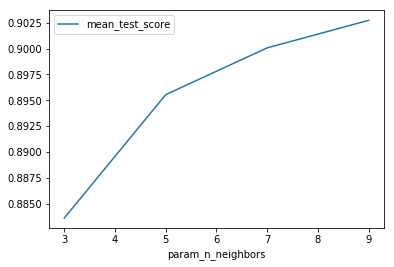

In [57]:
results_knn.plot('param_n_neighbors','mean_test_score')

In [ ]:
results.sort_values('mean_test_score', ascending = False)

#### RF

In [58]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV

In [ ]:
forest = RandomForestClassifier(n_estimators: 200)

In [59]:
forest = RandomForestClassifier(n_jobs=-1, random_state=0)

In [60]:
forest = forest.fit(train_x, train_y)

In [61]:
predicitons = forest.predict(test_x)

In [62]:
acc_rf = accuracy_score(test_y,predicitons)

In [63]:
print("Random forest accuracy: ",acc_rf)

Random forest accuracy:  0.897337370784


In [67]:
# print("Random forest accuracy: ",acc_rf)

Random forest accuracy:  0.812423417998


In [ ]:
print("Random forest accuracy: ",acc_rf)

In [50]:
parameters = {'n_estimators': [10,20,40,60,80,100,120,140,160]}

In [51]:
%%time

rf = GridSearchCV(forest, parameters, n_jobs=-1)
rf.fit(train_x, train_y)

CPU times: user 9min, sys: 3.71 s, total: 9min 4s
Wall time: 27min 21s


In [52]:
#rf

In [53]:
results = pd.DataFrame(rf.cv_results_)

/anaconda2/envs/snakes/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda2/envs/snakes/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda2/envs/snakes/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda2/envs/snakes/lib/python

In [54]:
results.sort_values('mean_test_score', ascending = False)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
8,305.706908,4.612562,0.905995,0.968601,160,{'n_estimators': 160},1,0.903993,0.968860,0.907532,0.968230,0.906459,0.968713,57.741624,1.911609,0.001482,0.000269
7,363.082461,9.209897,0.905878,0.968601,140,{'n_estimators': 140},2,0.904046,0.968846,0.907156,0.968257,0.906432,0.968699,11.259342,1.143468,0.001329,0.000251
6,330.674259,8.274602,0.905762,0.968574,120,{'n_estimators': 120},3,0.903912,0.968873,0.907022,0.968109,0.906351,0.968740,4.617961,0.581994,0.001336,0.000333
5,253.542909,9.093405,0.905744,0.968484,100,{'n_estimators': 100},4,0.903885,0.968766,0.907183,0.968082,0.906164,0.968605,2.629514,2.354426,0.001379,0.000292
4,197.414483,5.178100,0.905529,0.968386,80,{'n_estimators': 80},5,0.903590,0.968699,0.907022,0.967988,0.905976,0.968471,1.198933,0.088510,0.001436,0.000296
3,144.795827,3.619591,0.905306,0.968015,60,{'n_estimators': 60},6,0.903268,0.968417,0.906915,0.967666,0.905734,0.967961,1.057882,0.058013,0.001519,0.000309
2,94.961456,2.403636,0.904957,0.967062,40,{'n_estimators': 40},7,0.903000,0.967451,0.906298,0.966808,0.905573,0.966928,0.568293,0.414508,0.001415,0.000279
1,47.625226,1.106713,0.904483,0.963435,20,{'n_estimators': 20},8,0.902705,0.963775,0.905734,0.962863,0.905010,0.963668,1.421588,0.130389,0.001292,0.000407
0,29.563817,0.668364,0.902059,0.957362,10,{'n_estimators': 10},9,0.900639,0.957724,0.902729,0.957094,0.902809,0.957268,0.442877,0.074201,0.001005,0.000266


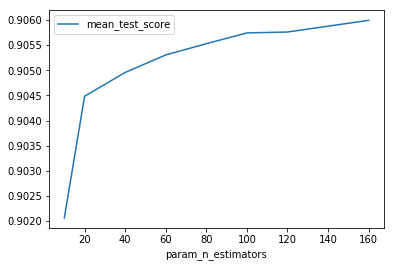

In [55]:
results.plot('param_n_estimators','mean_test_score')

### MLPClassifier Netural network

In [23]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix

In [24]:
mlp = MLPClassifier(random_state = 0)

In [25]:
mlp.fit(train_x, train_y)

/anaconda2/envs/snakes/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=0, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [26]:
predictions = mlp.predict(test_x)

In [33]:
print(classification_report(test_y,predictions))

             precision    recall  f1-score   support

          0       0.49      0.32      0.39      4653
          1       0.31      0.08      0.12       468
          2       0.61      0.45      0.52      2576
          3       0.00      0.00      0.00       135
          4       0.52      0.31      0.39      2397
          5       0.10      0.01      0.02       447
          6       0.92      0.96      0.94     42827

avg / total       0.84      0.83      0.83     53503



In [32]:
accuracy_score(test_y,predictions)

0.86997843789905582

In [58]:
parameters = {'hidden_layer_sizes' : [(50,), (100,), (784,), (50,50), (100,100), (784,784), (50,50,50), (100,100,100)] }

mlp_clf= GridSearchCV(mlp, parameters, n_jobs=-1)

In [ ]:
mlp_clf.fit(train_x, train_y)

results = pd.DataFrame(mlp_clf.cv_results_)
results.sort_values('mean_test_score', ascending = False)

/anaconda2/envs/snakes/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda2/envs/snakes/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda2/envs/snakes/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda2/envs/snakes/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged 

In [ ]:
results.plot('param_hidden_layer_sizes','mean_test_score')